### CITS5508 Labsheet 5

**Author: Lee de Byl (10306807)**<br>
**Date: 21 May 2021**

The objective of this labsheet is to construct both a Multi-Layer Perceptron (MLP), as well as a Convolutional Neural Network (CNN) to classify images in the CIFAR-10 dataset.

The CIFAR-10 dataset consits of 60,000 low resolution (32 x 32 pixel) colour images across ten classes. The classes are balanced (same number of examples per class). The dataset is further divided into a training set consisting of 50,000 images and a test set consisting of 10,000 images.

TensorFlow and Keras will be used to construct the neural networks, with support from scikit-learn for classification reports.

### A note on Kaya
Kaya was used for training of the MLP and CNN through direct execution of this notebook via iPython. A number of configuration paramters exist to optimise execution of the notebook depending on what type of environment it is running on. Whilst Kaya was effective for training, the lack of an interactive environment led to an increase in complexity. A number of shell scripts were used to transfer data between the interactive terminal and Kaya, which added to the development time.

### Preparations

Firstly, we import necessary libraries:

In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import pickle
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from data_loader import DataLoader
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from itertools import product, chain
from IPython.core.display import HTML
from collections import namedtuple

Set control parameters for the script. These can be modified depending on whether the script is running locally or on a remote compute cluster.

In [2]:
# GRID_SEARCH: Should grid searches be performed when running the notebook.
GRID_SEARCH_MLP = False
GRID_SEARCH_CNN = False

# GRID_SEARCH_WITHOUT_GPU: If False, prevents grid searches from running
# in the absence of a GPU. Allows testing of notebook on non-GPU machines.
GRID_SEARCH_WITHOUT_GPU = False

# FILE_PREFIX: Filename prefix for files generated by the script.
FILE_PREFIX = 'deByl_Lee-'

# FORCE_TRAINING: Force all models to be retrained from scratch, even if a saved model exists.
# This is equivalent to deleting the model from disk. If this is false, models will be loaded
# from disk and trained for 1 epoch.
FORCE_TRAINING = False

# Directory names that will be used for saving models.
# Will be prefixed with FILE_PREFIX
MLP_MODEL_DIRECTORY = FILE_PREFIX + 'MLP'
CNN_MODEL_DIRECTORY = FILE_PREFIX + 'CNN'

# EPOCHS: Maximum number of epochs to train for.
# Note that early stopping applies.
EPOCHS = 100

# MAX_GRID_SEARCHES: Maximum size of the parameter space to explore when
# performing a grid search. Set to None for no limit. Useful when testing.
MAX_GRID_SEARCHES = None

# VALIDATION_PC: Percentage of the training set that will be reserved for validation.
VALIDATION_PC = 0.20

# TENSORFLOW_VERBOSITY: Verbosity level for TensorFlow. Recommend 0 or 2 for
# non-interactive sessions.
TENSORFLOW_VERBOSITY = 2

# HISTORY_FILE: Pickle file that will store training data useful
# for visualisation
HISTORY_FILE = FILE_PREFIX + 'results.pickle'

# Set various random seeds.
RANDOM_SEED = 6
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

### Load the Dataset

The dataset is spread across a number of "batch" files. A module has been provided to read these and return them as a consolidated data structure. Some simple verification of assumptions will also be performed.

In [3]:
# According to the CIFAR-10 website, the training set is split into five batches
# stored in fives files. Each colour image has dimensions equal to 32 x 32 x 3. There
# are 10 classes.
image_width, image_height, image_Nchannels = 32, 32, 3
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
class_count = len(class_names)
X_train_complete, y_train_complete = DataLoader.load_batch('data_batch')
X_test, y_test = DataLoader.load_batch('test_batch', Nbatches=1)

input_shape = (image_width, image_height, image_Nchannels)
output_shape = class_count

# Validate the data is scaled and the number of classes
# matches the number of class names provided
assert y_train_complete.max() - y_train_complete.min() + 1 == class_count, 'Class Name mismatch: Number of classnames does not match number of target classes in training set'
assert X_train_complete.min() >= 0.0 and X_train_complete.max() <= 1.0, 'Image data not scaled.'


#### Validation Split
A portion of the training set, known as the validation set, will be reserved for assesing model performance during the training phase. In this case, 20% will be reserved for validation.

It is interesting to note that each image effectively consists of 3,072 separate features.

In [4]:
# You need to split the training set to form a validation set. The original
# training set would become smaller.
n_training_complete = len(X_train_complete)
n_training = round(1.0 - VALIDATION_PC * n_training_complete)
X_train, X_validation = X_train_complete[:n_training], X_train_complete[n_training:]
y_train, y_validation = y_train_complete[:n_training], y_train_complete[n_training:]

# Print some information about our dataset.
feature_count = image_width * image_height * image_Nchannels
print (f"Number of features per image: {feature_count}")
print (f"X_test.shape: {X_test.shape}\ny_test.shape: {y_test.shape}")
print (f"X_train.shape: {X_train.shape}\ny_train.shape: {y_train.shape}")

Number of features per image: 3072
X_test.shape: (10000, 32, 32, 3)
y_test.shape: (10000,)
X_train.shape: (40001, 32, 32, 3)
y_train.shape: (40001,)


### Image Plot
A selection of 20 random images will be be displayed to visualise the dataset.

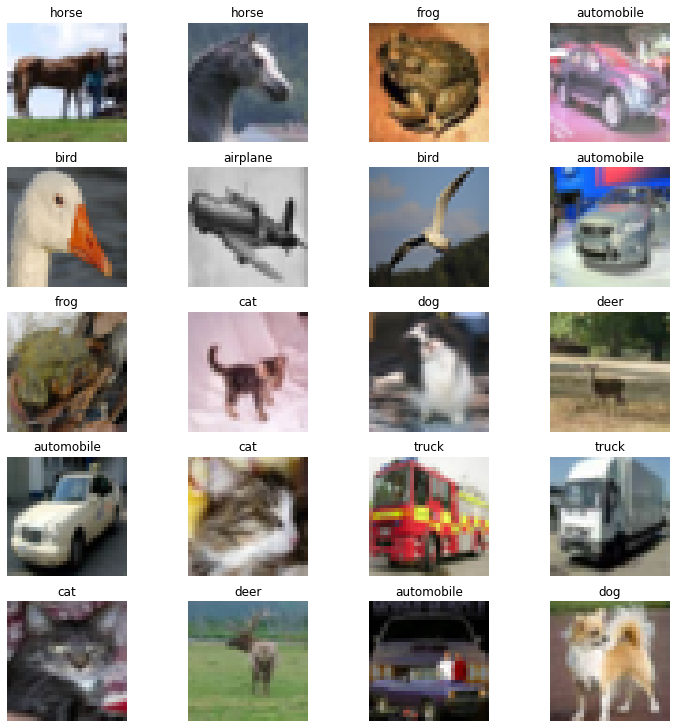

In [5]:
def resolve_labels(labels, names):
    """
    Given a list of label indices, and an ordered set of names,
    returns a list of labels.
    
    @param labels:
        A list of label indices. e.g. [1, 6, 7 ...]
    @param names:
        A list of label names. e.g. ['Dog', 'Cat']
    @returns:
        A list of label names corresponding to the input labels
    """
    return [names[i] for i in labels]

def image_grid(images, labels, n_images=20, figsize=(10,10)):
    """
    Displays a grid of images with labels. The number of rows
    and columns is automatically determined.
    
    To-Do: Determine the aspect ratio of rows and columns
    based on figsize, rather than assuming a square.
    
    @param images (type: array-like):
        An array of images of shape (nimages, width, height, channels)
    @param labels:
        A list of of labels to be displayed along with each image.
    @param n_images:
        Total number of images to display. The dimensions
        (rows/cols) of the image grid will automatically
        be determined.
        
        The specified number of images will be randomly selected
        from the set of images supplied.
        
        Defaults to 20
    @param figsize:
        Dimensions of the resultant plot.
    """
    # Validate that more images haven't been requested than supplied.
    assert n_images <= len(images), 'More images requested than supplied'
    
    # Calculate the number of rows and columns required.
    columns = round(math.sqrt(n_images))
    rows = math.ceil(n_images / columns)
    
    fig, ax = plt.subplots(rows,columns, figsize=figsize, constrained_layout=True)
    
    n = len(images)
    for k,(i,j) in enumerate(product(range(rows),range(columns))):
        idx = np.random.choice(n)
        ax[i][j].set_axis_off()
        if k < n_images:
            ax[i][j].imshow(images[idx,:])
            ax[i][j].set_title(labels[idx])
            
# Plot 20 random images with labels.
image_grid(X_test, resolve_labels(y_test, class_names))

## Multi-Layer Perceptron Grid Search

In this section a grid search is performed to approximate parameters for maximising accuracy of the MLP model. This is only executed if `GRID_SEARCH=True`. The optimal model, along with the training history, will be written to a file.

Firstly, functions for performing the grid search will be defined. Whilst sklearn could have been used to perform the grid search, or some other hyperparameter optimisation technique, by using the Keras Tensorflow wrapper, a decision was made to implement a simple grid search. This also enables callbacks to the Keras fit function to be incorporated into the grid search.

These functions will also be used for the CNN.

In [6]:
# A wrapper around callback functions to allow
# pretty-printing of names.
Callback = namedtuple('Callback', ['name', 'function'])

def load_history(filename=HISTORY_FILE):
    """
    Loads grid search and history data from the specified
    pickle file. Used primarily for transferrring training
    history and grid search results more elegant from Kaya.
    If the pickle file does not exist, returns an empty dict.
    """
    # Load the visualisation data file, or create a new visualisation data structure.
    # This file is used to transfer data between Kaya and Jupyter notebooks.
    history_data = {}
    if os.path.isfile(filename):
        with open(filename, 'rb') as f:
            history_data = pickle.load(f)
    return history_data

def save_history(data, filename=HISTORY_FILE):
    """
    Saves gridsearch and history data to a pickle file.
    Useful for transferring grid search and training
    efficiency data from Kaya.
    
    Data is any serializable object.
    """
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
        
def make_filename(filename, prefix=FILE_PREFIX):
    """
    Given a filename, prepends the FILE_PREFIX prefix
    
    @param filename: String representing the desired filename.
    @param prefix: Prefix to be used. Defaults to FILE_PREFIX.
    @returns A string representing the destination filename.
    """
    return FILE_PREFIX + filename

def static_lr(static_lr=0.01):
    """
    Creates a keras Learning Rate callback that returns
    a static, fixed value. This is useful in a grid search where
    both learning rate schedules, as well as a range of fixed learning rates
    should be explored. An alternative implementation of this could use
    functools.partial.
    
    @params static_lr: The desired constant learning rate
    @returns a LearningRateScheduler that always returns static_lr
    """
    def cb(epoch, lr):
        "The callback that will be used to create the LearningRateScheduler"
        return static_lr
    return keras.callbacks.LearningRateScheduler(cb)

def simple_lr_scheduler(epoch, lr):
    """
    A simple learning rate scheduler that uses a fixed
    learning rate for the first 10 epochs, then
    diminishes it exponentially.
    
    @param epoch: The current epoch
    @param lr: The current learning rate
    @returns the new learning rate.
    """
    return lr if epoch < 10 else lr * tf.math.exp(-0.1)

def dict_product(d):
    """
    Similar to itertools.product, but for dictionaries of lists.
    This is used to generate the parameter space to be explored for
    the grid search.
    
    @params dicts
        A collection of dictionaries that the product should be found for
    
    @returns
        A collection of dictionaries, each with one value per key,
        taken from the list associated with each key in d
    """
    return (dict(zip(d, x)) for x in product(*d.values()))

def get_best_parameters(results, metric='val_accuracy'):
    """
    Given the output from a grid search, finds the set
    of parameters that maximises the given metric.
    
    @param results
        The results as returned from run_grid_search
    @param metric
        The metric to maximise. Must be returned by Keras
    @returns
        The entry in results that maximises the given metric.
    """
    return max(results, key=lambda x: x[1].history[metric][-1])

def print_parameters(parameters):
    """
    Pretty prints a dictionary of model parameters.
    
    @param parameters
        A dictionary of name: value pairs to be printed.
    """
    print('Parameters:')
    for name, value in parameters.items():
        print(f'  {name}: {value}')

def training_required(model_dir):
    """
    Given the destination path of a Keras Model, returns
    true if the model doesn't exist, or if FORCE_TRAINING
    is true.
    
    @param model_dir
        The directory that contains a model that should
        prevent training from occuring if it exists.
    
    @returns
        True if a model directory does not exist, or FORCE_TRAINING
        is set to True. False otherwise.
    """
    return FORCE_TRAINING or not os.path.isdir(model_dir)

def training_plot(results, title=None):
    """
    Plots training progress of the best training run from a grid search
    by epoch.
    
    @param results
        Training results to plot, as returned by a grid search
    @param title
        Optional title to display.
    """
    best_index = results[2]
    results = results[0][best_index][1]
    plt.plot(results['accuracy'])
    plt.plot(results['val_accuracy'])
    #plt.plot(results['lr'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['Training Set', 'Validation Set'], loc='lower right')
    plt.show()

def run_grid_search(model_maker, X_train, y_train, X_validation, y_validation, parameters, verbose=TENSORFLOW_VERBOSITY, metric='val_accuracy', epochs=EPOCHS, max_searches=MAX_GRID_SEARCHES):
    """
    Runs a grid search for a model. Note that this function can
    optimise not just model parameters, but also training paramters
    and callbacks.
    
    @param model_maker
        A function that, given a set of parameters, returns a
        compiled Keras model.
    @param X_train
        Data to train the model on.
    @param y_train
        Data to train the model on.
    @param X_validation
        X data to validate model performance on.
    @param y_validation
        y data to validate model performance on.
    @param parameters
        Model, callback and fitting paramters to try. Should
        be a dictionary of parameter names to be passed to
        model_maker (will be splatted in).
        
        Each parameter should map to a list of values to be 
        tried. All permutations of these parameters will be
        explored, up to a limit specifed by MAX_SEARCHES.
        
        Parameters of type Callback will not be passed
        to "model_maker" and will instead be used to create
        a set of callbacks to be used for model fitting. Values
        of None will be ignored.
    @param epochs
        The maximum number of epochs to train for. Defaults
        to MAX_EPOCHS
    @param verbose
        The Keras verbosity level. Defaults to TENSORFLOW_VERBOSITY
    @param metric
        The Keras metric name to optimise for. Defaults to validation
        accuracy.
    @returns
        A tuple containing:
         - all_results:
             The collection of all parameters explored
             and the training history provided by keras.
         - best_score: The overall best score found (scalar)
         - best_index: The index in all_results that has the best score
         - best_model: The best Keras model. Other models are discarded
           to save memory.
    """

    # Check there is a GPU, or performing a grid search without a GPU is enabled
    assert tf.config.list_physical_devices("GPU") or GRID_SEARCH_WITHOUT_GPU, 'No GPU available.'
    
    all_results = []
    best_model = None
    best_score = None
    best_index = None
    
    cases = list(enumerate(dict_product(parameters)))
    print(f'Total number of cases: {len(cases)}')
    
    for i, p in cases:
        # i is the case number, p is the set of parameters
        # and callbacks combined for this case.
        if max_searches and i >= max_searches:
            break
        
        print(f'--- Case Number {i} ---')
        
        # Callbacks require special treatment
        # Take any parameters in our gridsearch of type Callback
        # and put them in their own list
        callbacks = [value.function for param, value in p.items() if type(value) == Callback]
        parameters = {name: value for name, value in p.items() if type(value) != Callback}

        print_parameters(parameters)
        print(f'Number of callbacks: {len(callbacks)}')

        model = model_maker(input_shape, output_shape, **parameters)        
        results = model.fit(X_train, y_train, verbose=verbose, epochs=epochs, callbacks=callbacks, validation_data=(X_validation, y_validation))
        score = results.history[metric][-1]
        print(f'Score: {score}')
        
        # Combine callbacks and parameters into a serializable format
        # These will eventually be pickled for visualisation
        serializable_parameters = {name: value.name if type(value) == Callback else str(value) for name, value in p.items()}
        all_results.append([serializable_parameters, results.history])
        
        # Note ordering of comparisons below is important.
        # Update statistics on best model performance
        if not best_score or score > best_score:
            best_model = model
            best_score = score
            best_index = i
            
        print('--- End of Case ---', flush=True)
        
    # Print the final optimal results
    print('----- End of Grid Search -----')
    print(f'Best Score: {best_score}')
    print_parameters(all_results[best_index][0])
    print('------------------------------')
    return all_results, best_score, best_index, best_model

#### Define the MLP Model Topology
Next we define a function for producing an MLP model based on supplied parameters. This function will be called by the grid search to generate the models required for comparison.

The sequential MLP has the following topology:
* An input layer that flattens the 3,072 data points comprising an image;
* Densely connected hidden layers with the specified kernel initialization function and activation function. The number of hidden layers - and the number of nodes within them - was set at 2 layers, with the first layer having 200 nodes, and the second having 100. This was found with experimentation outside of the grid search performed here. The number of layers can be set with a parameter, and could be further optimised with a grid search.
* An output layer with 10 nodes, using softmax activation.
* Dropout layers between all layers.

In [7]:
def make_mlp_model(input_shape=input_shape, output_shape=output_shape, activation='relu', dropout_rate=0, initializer='random_normal', hidden_layers=(200,100), lr_schedule=None):
    """
    Creates and compiles a new MLP model with the specified parameters.
    
    @param input_shape
        Input shape of the data - for first layer
    @param output_shape
        Output shape of the data - for the last layer
    @param activation
        Activation function to use for everything but last layer,
        which will use softmax
    @param dropout_rate
        Dropout rate to use between layers
    @param initializer
        Kernel initialization
    @param hidden_layers
        Number of nodes per hidden layer
    @param lr_schedule
        Learning rate to be given the the SGD Optimiser
        May be a callback or fixed value
    @returns
        A compiled Keras model
    """
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shape))
    model.add(keras.layers.Dropout(dropout_rate))
    for n in hidden_layers:
        model.add(keras.layers.Dense(n, activation=activation, kernel_initializer=initializer))
        model.add(keras.layers.Dropout(dropout_rate))    
    model.add(keras.layers.Dense(output_shape, activation='softmax', kernel_initializer=initializer))

    if lr_schedule:
        sgd = keras.optimizers.SGD(learning_rate=lr_schedule)                
    else:
        sgd = keras.optimizers.SGD()                  
                  
    model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=["accuracy"])
    return model

# Create an Exponential Learning Rate callback to use
exponential_lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.90)

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

#### Perform the Grid Search
If grid searching is enabled, perform the grid search. The best model will be written to disk, along with the training history data for visualisation and future analysis.

We compare a number of parameters:
* Kernel Initializer: Random Normal or He Normal
* Dropout Rate: 0.0 (no dropout) or 0.25
* Learning Rate Scheduler: Reduce on Plateu vs Exponential Decay

A note on the Learning Rate Scheduler: the grid search architecture supports testing of learning rate scheduling as part of the model definition, as well as part of the fit process. Callbacks encased in the `Callback` type will be sent to the fit function; all other callbacks will be sent to the model.

In [8]:
# Load history data from pickle, either to be updated
# or displayed.
history_data = load_history()

if GRID_SEARCH_MLP:
    grid_parameters = {
        'initializer': ['random_normal', 'he_normal'],
        'hidden_layers': [(200,100)],
        'dropout_rate': [0.0, 0.25],
        'lr_schedule': [exponential_lr, Callback('plateau', ReduceLROnPlateau(patience=3))],
        'early_stopping': [Callback('early_stopping', early_stopping)]
    }

    all_results, best_score, best_index, best_model = run_grid_search(make_mlp_model, X_train, y_train, X_validation, y_validation, grid_parameters, max_searches=MAX_GRID_SEARCHES, verbose=TENSORFLOW_VERBOSITY)
    best_model.save(MLP_MODEL_DIRECTORY)  
    
    # Save the history data to the dictionary of results
    # and pickle it for persistance. 
    history_data['mlp'] = (all_results, best_score, best_index)
    save_history(history_data)

## Training the MLP
Once reasonable parameters of the MLP have been ascertained, the model can be trained. If the model file does not exist, the model will be fully trained and written to a file. Otherwise, the model will be loaded and trained for one additional epoch. This is handled by the function `init_or_load_model`, which is used for the MLP and CNN.

The optimal MLP Model parameters, as found by a grid search, are:
* Learning Schedule: Plateau Learning Rate Reduction
* Early Stopping: Yes
* kernel initialization: he_normal
* dropout_rate: 0.25
* hidden_layers: 200, 100
    


In [9]:
def init_or_load_model(model_dir, model_fn, X_train, y_train, X_validation, y_validation, params, callbacks=None, save=False):
    """
    If model_dir exists, load the Keras model that exists in that
    directory and train it for 1 epoch. If it does not exist,
    create a new Keras model and train it for up to 100 epochs.
    
    Displays a summary of the model prior to training
    
    @param model_dir
        Directory (potentially) containing a Keras model
    @param model_fn
        Function to call to create and compile a new model.
        The params function will be passed to it.
    @param X_train, y_train, X_validation, y_validation
        Data for training the model
    @param params
        Dictionary of parameters to be passed to model_fn
    @param callbacks
        List of callbacks to be used when fitting the model
    @param save
        If the model is trained from scratch, should it be saved?
    @returns Tuple(model, results)
        Model is the Keras model
        Results are the results provided by keras.fit
    """
    callbacks = callbacks if callbacks else []
    if not training_required(model_dir):
        # The model path exists: Load the model, and set the number
        # of epochs to 1
        epochs = 1
        print(f"Loading previously saved model and training for {epochs} epoch(s)")
        model = tf.keras.models.load_model(model_dir)
        model.summary()
        results = model.fit(X_train, y_train, verbose=TENSORFLOW_VERBOSITY, epochs=epochs, callbacks=callbacks, validation_data=(X_validation, y_validation))
    else:
        epochs = EPOCHS
        print(f"Initialising new model and training for {epochs} epochs.")
        model = model_fn(**params)
        model.summary()   
        results = model.fit(X_train, y_train, verbose=TENSORFLOW_VERBOSITY, epochs=epochs, callbacks=callbacks, validation_data=(X_validation, y_validation))
        if save:
            print(f"Saving model to {model_dir}")
            model.save(model_dir)    
    return model, results

Perform the load and train, or initialise and train, operation and display details of the model.

In [10]:
# Load the saved MLP model, if it exists, and train
# it for one epoch, or create a new model with
# the specified parameters.

# These are the "optimal" hyperparameters as found in a grid search.
callbacks = [early_stopping, ReduceLROnPlateau(patience=3)]
model_parameters = {
    'initializer': 'he_normal',
    'hidden_layers': (200,100),
    'dropout_rate': 0.25
    }

mlp_model, mlp_results = init_or_load_model(
    MLP_MODEL_DIRECTORY,
    make_mlp_model,
    X_train, y_train,
    X_validation, y_validation,
    model_parameters,
    callbacks
    )

Loading previously saved model and training for 1 epoch(s)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 3072)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 200)               614600    
_________________________________________________________________
dropout_22 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_23 (Dropout)         (None, 100)               0         
_____________________________________________________________

### Training History Plot
Plot the accuracy by epoch for the model. Data from the grid search, if available, is used here.

Note the oscillations in the training of the validation set.

In [11]:
if 'mlp' in history_data:    
    training_plot(history_data['mlp'])

Define a function to display a classification report, and run this on the test set for the MLP.

In [12]:
def show_classification_report(X, y_actual, model, dataset_name, class_names=class_names):
    """
    Displays a classification report for a model, including
    a confusion matrix and a per-class and overall accuracy summary.
    
    The report also includes a grid of images and their actual and
    predicted labels.
    
    @param X:
        X values upon which predictions should be made
    @param y_actual: The actual (ground-truth) values to which the 
        predictions should be compared, as a list of integers.
    @param model:
        A model-like obhect with a predict method.
    @dataset_name:
        The name of the dataset to which X and y_actual pertain.
        Used for the graph title.
    @class_names:
        Used to resolve class indexes in Y_actual and the predicted
        valus from the supplied model to meaningful display names.
    """
    y_actual = resolve_labels(y_actual, class_names)
    y_pred = model.predict(X).argmax(axis=-1)
    y_pred = resolve_labels(y_pred, class_names)

    display(HTML(f'<h3>Classification Report - {dataset_name}</h3>'))
    
    cm = confusion_matrix(y_actual, y_pred)
    cm = ConfusionMatrixDisplay(cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(15,10))
    ax.set_title(f'Confusion Matrix - {dataset_name}')
    print(classification_report(y_actual, y_pred))
    cm.plot(ax=ax);
    
    # Display the classification results as an image grid
    img_labels = [f'Predicted: {pred}\nActual: {actual}' for pred, actual in zip(y_pred, y_actual)]
    image_grid(X, img_labels)
    
    

              precision    recall  f1-score   support

    airplane       0.58      0.51      0.54      1000
  automobile       0.64      0.58      0.61      1000
        bird       0.36      0.27      0.31      1000
         cat       0.37      0.33      0.35      1000
        deer       0.39      0.45      0.42      1000
         dog       0.45      0.28      0.35      1000
        frog       0.44      0.69      0.54      1000
       horse       0.58      0.52      0.55      1000
        ship       0.53      0.70      0.61      1000
       truck       0.55      0.55      0.55      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.48     10000
weighted avg       0.49      0.49      0.48     10000



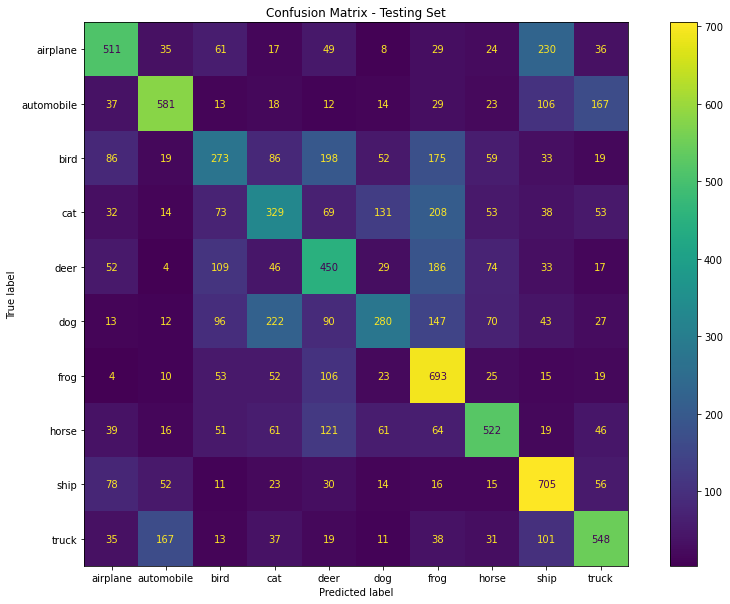

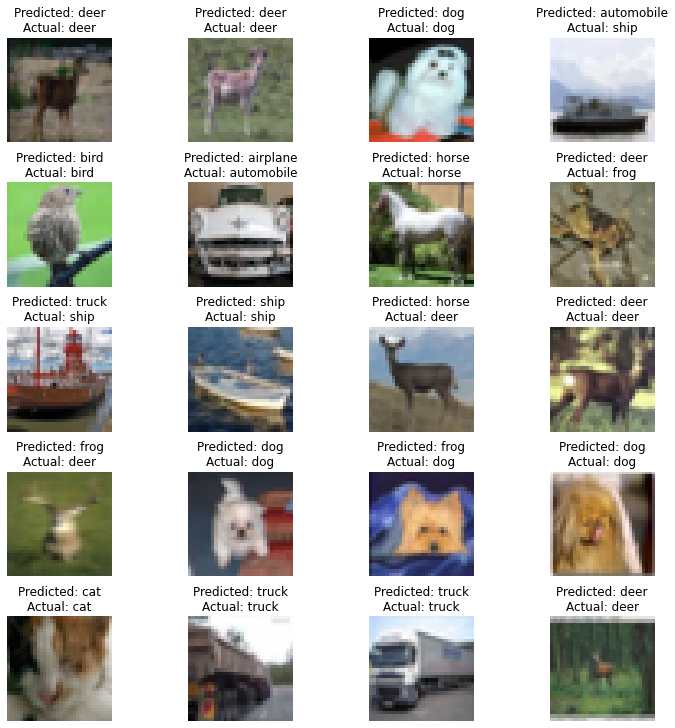

In [13]:
show_classification_report(X_test, y_test, mlp_model, 'Testing Set')

#### Notes on MLP Performance
The MLP had an average F1 score of 48% on the testing set, and overall accuracy of 49%. It's interesting to note from the confusion matrix that, where the MLP failed to predict correctly, in many cases the overall class of prediction was roughly correct. For example, trucks were most commonly mislabeled as automobiles or ships. Similarly, birs were most commonly mislabelled as deers or frogs, rather than ships.

## Implementation of a CNN

Next, we implement a Convolutional Neural Network to attempt the same classification task.

We explore settings for the following three parameters using a grid search:
* Kernel Size
* Number of Kernels
* Activation Function

Where possible, we keep the optimal parameters discovered from the MLP the same, such as kernel initialisation.

The overall architecture is as follows:
* Three convolutional layers with the same size kernel (3x3), but varying numbers of filters (32, 128,256)
* Batch Normalisation and Max Pooling between convolutional layers
* A flattening layer between the convolutional layer and the fully connected layer.
* A fully connected layer similar to that of the MLP.

In [14]:
def make_cnn_model(input_shape=input_shape, output_shape=output_shape, kernel_size=3, filters=(32,128,256), dropout_rate=0.25, activation='relu', lr_schedule=None, initializer='he_normal', **kwargs):
    model = keras.models.Sequential([
        keras.layers.Conv2D(filters[0], kernel_size, activation=activation, padding='same', input_shape=input_shape, kernel_initializer=initializer),
        keras.layers.MaxPooling2D(2),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters[1], kernel_size, activation=activation, kernel_initializer=initializer),
        keras.layers.MaxPooling2D(2),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters[2], kernel_size, activation=activation, kernel_initializer=initializer),
        keras.layers.MaxPooling2D(2),
        keras.layers.BatchNormalization(),
        keras.layers.Flatten(),
        keras.layers.Dense(200, activation=activation, kernel_initializer=initializer),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(100, activation=activation, kernel_initializer=initializer),
        keras.layers.Dropout(dropout_rate),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(output_shape, activation='softmax')
    ])

    if lr_schedule:
        sgd = keras.optimizers.SGD(learning_rate=lr_schedule)
    else:
        sgd = keras.optimizers.SGD()
        
    model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=["accuracy"])
    return model

if GRID_SEARCH_CNN:
    grid_parameters = {
        'early_stopping': [Callback('early_stopping', early_stopping)],
        'activation': ['relu','tanh'],
        'kernel_size': [3,5],
        'filters': [(32,128,256), (16,32,64)],
        'lr_schedule': [Callback('plateau', ReduceLROnPlateau(patience=3))]
    }
    
    # Perform the grid search
    all_results, best_score, best_index, best_model = run_grid_search(make_cnn_model, X_train, y_train, X_validation, y_validation, grid_parameters, max_searches=MAX_GRID_SEARCHES, verbose=TENSORFLOW_VERBOSITY)
    # Save the best trained CNN to disk
    best_model.save(CNN_MODEL_DIRECTORY)
    
    # Save the history data to the dictionary of results
    # and pickle it for persistance. 
    history_data['cnn'] = (all_results, best_score, best_index)
    save_history(history_data)

##### Grid Search Training Graph
If available, plot accuracy of the model during training on the validation set per epoch. This is based on the best model from the grid search.

In [15]:
if 'cnn' in history_data:    
    training_plot(history_data['cnn'])

### CNN Model Training
The grid search determined that the ideal parameters are those documented below. These are the parameters that will be used to initialise a new model, should one not be able to be loaded from disk (or `FORCE_TRAIN` is set to True). The model below had accuracy of roughly 71.8% on the validation set. 

* Kernel Size: 3x3
* Filters - Layer 1: 32
* Filters - Layer 2: 128
* Filters - Layer 3: 256
* Activation Function: relu

Other parameters were maintained from the MLP Grid Search:
* Learning Rate Scheduling: Plateau (Patience: 3)
* Kernel Initialization: he_normal
* Dropout Rate: 0.25

In [16]:
# These are the optimal hyperparameters found using the grid search above.
callbacks = [early_stopping, ReduceLROnPlateau(patience=3)]
model_parameters = {
  'initializer': 'he_normal',
  'dropout_rate': 0.25,
  'activation': 'relu',
  'kernel_size': 3
}
  
cnn_model, cnn_results = init_or_load_model(
    CNN_MODEL_DIRECTORY,
    make_cnn_model,
    X_train, y_train,
    X_validation, y_validation,
    model_parameters, callbacks
    )

Loading previously saved model and training for 1 epoch(s)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_____________________________________________________________

### CNN - Performance on Test Set
The performance of the trained CNN can be evaluated on the test set, which was not used during training or hyperparameter tuning, to validate the overall efficacy of the model.

The overall accuracy and average F1 score on the testing set is 72%, which very closely matches that seen on the validation set (71.85%). Macro precision and recall were also 72%.

              precision    recall  f1-score   support

    airplane       0.75      0.75      0.75      1000
  automobile       0.83      0.81      0.82      1000
        bird       0.63      0.58      0.61      1000
         cat       0.54      0.56      0.55      1000
        deer       0.67      0.68      0.68      1000
         dog       0.65      0.60      0.62      1000
        frog       0.76      0.80      0.78      1000
       horse       0.74      0.74      0.74      1000
        ship       0.81      0.82      0.81      1000
       truck       0.77      0.81      0.79      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



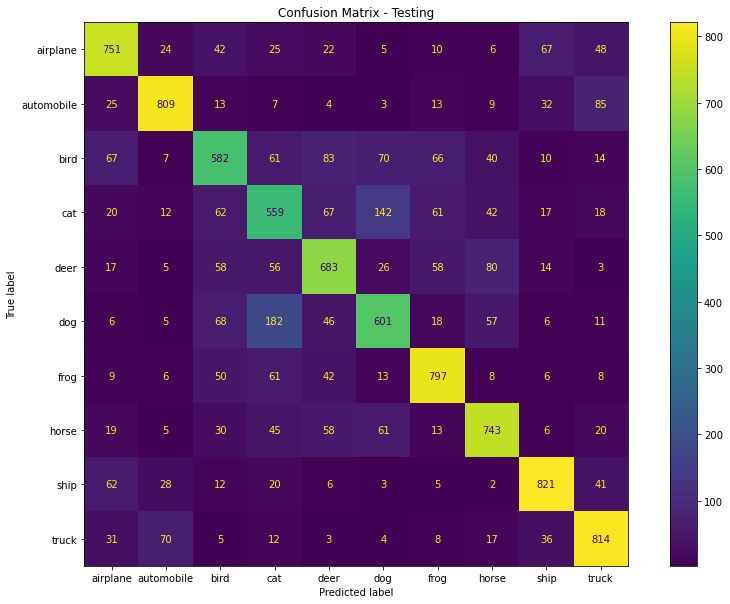

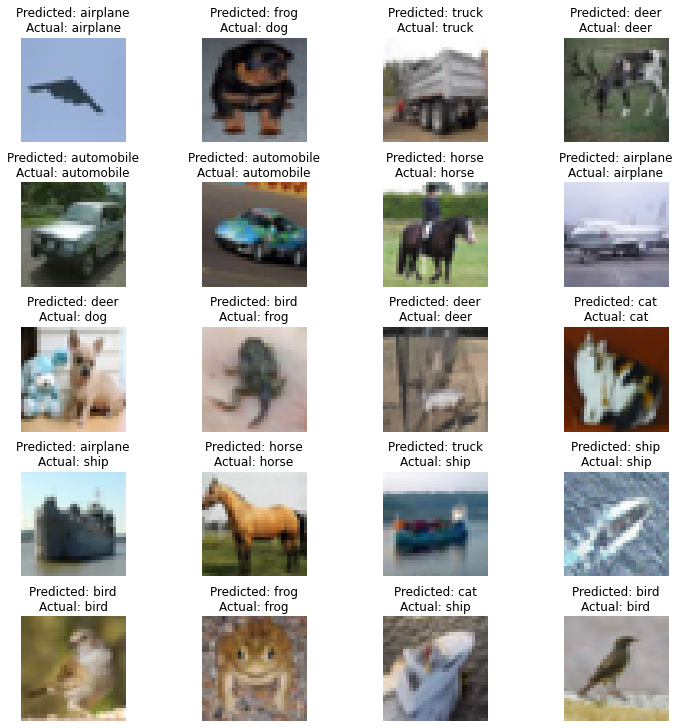

In [17]:
show_classification_report(X_test, y_test, cnn_model, 'Testing')

## Comparison of the performance of the MLP vs the CNN

On the test set, the MLP achieves classification accuracy performance of 49%, vs 72% for the Convolutional Neural Network - an incease of 22%. However, it is also significantly more computationally intensive to train. The use of convolutional layers allows higher-level features, and relationships between features, to be identified. This is in contrast to the MLP which relies more on the value of individual pixels at fixed locations to perform the classification task.

The more complex architecture of the CNN leads to a dramatic increase in the number of hyperparameters and design choices to be optimised, which potentially increases the time required to optimse it.

It is visually apparent that the images are of very low resolution, and in many cases from a human perspective the object remains somewhat ambiguous. It is impressive that both networks performed as well as they did with the limited amount of resolution available.

Finally, it is interesting to observe that with both networks, where misclassifications occured, the incorrect prediction was of the same overall type as the ground truth: for example, dogs were confused with cats, horsese with deer etc, rather than ships being confused with dogs. 